<a href="https://colab.research.google.com/github/anphantt2406/Heritage-Health-Prize/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/HHP_release3/new_data

Mounted at /content/drive
/content/drive/My Drive/HHP_release3/new_data


#Import Library

In [ ]:
import glob
import math
import pandas as pd
import numpy as np
import xgboost
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

import seaborn as sns # Library for plotting
color = sns.color_palette()
sns.set_style('darkgrid')
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

#Define some needed function

Predictions are evaluated using root mean squared logarithmic error, referred to henceforth as RMSLE.

$$\varepsilon = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(log(p_i+1) - log(a_i+1)^2 \right )}$$

Where:



*   $i$ is a patient's unique MemberID
*   $n$ is the total number of patients
*   $p_i$ is the prediction made for patient $i$
*   $a_i$ is the actual number of days spent in the hospital by patient $i$





In [ ]:
def RMSLE_cal(pred, actu, name=None):
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    print('RMSLE', name, ':', RMSLE)

In [ ]:
def rmsle(pred, dtrain):
    """Used for stacked in Xgboost
    """
    actu = dtrain.get_label()
    RMSLE = round(np.sqrt(((np.log(pred + 1) - np.log(actu + 1)) ** 2).sum() / actu.shape[0]), 6).item()
    return 'RMSLE', RMSLE

In [ ]:
def eval(model, X_test, y_test):
    pred_y = model.predict(X_test) # your predicted y values
    # The root mean square logarithmic error
    pred_y = pred_y.clip(min=0)
    pred_y = pred_y.clip(max=15)
    pred_y = pred_y.round(0).astype(int)
    msle = np.mean( (np.log(pred_y + 1) - np.log(y_test + 1)) ** 2)
    rmsle = math.sqrt(msle)
    print ("RMSLE: %.2f" % rmsle)
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test,pred_y)
    print ("R2 value: %.2f" % r2)
    from sklearn.metrics import mean_squared_log_error
    err = math.sqrt(mean_squared_log_error(y_test,pred_y))
    print ("Err value: %.2f" % err)

In [ ]:
def plotResult(results, cv=None):
    fig, ax = plt.subplots()
    if cv:
        ax.plot(range(results.shape[0]), results['train-RMSLE-mean'])
        ax.plot(range(results.shape[0]), results['test-RMSLE-mean'])
    else:
        ax.plot(range(len(results['train']['RMSLE'])), results['train']['RMSLE'])
        ax.plot(range(len(results['test']['RMSLE'])), results['test']['RMSLE'])
        
    ax.set(xlabel='Boost round', ylabel='RMSLE', title='Train/Test RMSLE')
    ax.grid()

    train_patch = mpatches.Patch(color='blue', label='Train')
    test_patch = mpatches.Patch(color='orange', label='Test')

    plt.legend(handles=[train_patch, test_patch])
    plt.show()

#Prepare data for training and testing

In this notebook, we use Claims data in Year 1 for training and validation, Claims data in Year 2 for testing.

In [ ]:
dataY1_df = pd.read_csv('fulldataY1.csv')
dataY2_df = pd.read_csv('fulldataY2.csv')

In [ ]:
dataY1 = dataY1_df.drop(['MemberID'], axis = 1)
y = dataY1['CLASS']
X = dataY1.drop(['CLASS', 'TARGET'], axis = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

dataY2 = dataY2_df.drop(['MemberID'], axis = 1)
y_test = dataY2['CLASS']
X_test = dataY2.drop(['CLASS', 'TARGET'], axis = 1)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
dataY2_df

,MemberID,AgeAtFirstClaim,Male,Female,Unknown,no_Claims,no_Providers,no_Specialties,no_PCG,no_Procedure,sum_PayDelay,sum_LOS,Specialty_Anesthesiology,Specialty_Diagnostic Imaging,Specialty_Emergency,Specialty_General Practice,Specialty_Internal,Specialty_Laboratory,Specialty_Obstetrics and Gynecology,Specialty_Other,Specialty_Pathology,Specialty_Pediatrics,Specialty_Rehabilitation,Specialty_Surgery,Place_Ambulance,Place_Home,Place_Independent Lab,Place_Inpatient Hospital,Place_Office,Place_Other,Place_Outpatient Hospital,Place_Urgent Care,DSFS_0- 1 month,DSFS_1- 2 months,DSFS_10-11 months,DSFS_11-12 months,DSFS_2- 3 months,DSFS_3- 4 months,DSFS_4- 5 months,DSFS_5- 6 months,...,PCG_PERVALV,PCG_PNCRDZ,PCG_PNEUM,PCG_PRGNCY,PCG_RENAL1,PCG_RENAL2,PCG_RENAL3,PCG_RESPR4,PCG_ROAMI,PCG_SEIZURE,PCG_SEPSIS,PCG_SKNAUT,PCG_STROKE,PCG_TRAUMA,PCG_UTI,Charlson_0,Charlson_1-2,Charlson_3-4,Charlson_5+,Procedure_ANES,Procedure_EM,Procedure_MED,Procedure_PL,Procedure_RAD,Procedure_SAS,Procedure_SCS,Procedure_SDS,Procedure_SEOA,Procedure_SGS,Procedure_SIS,Procedure_SMCD,Procedure_SMS,Procedure_SNS,Procedure_SO,Procedure_SRS,Procedure_SUS,DrugSum,LabSum,TARGET,CLASS
0,4,5,1,0,0,1,1,1,1,1,43,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
1,210,35,0,0,1,6,3,3,2,3,308,0,0,0,0,0,1,1,0,4,0,0,0,0,0,0,1,0,5,0,0,0,2,0,0,0,0,2,0,0,...,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1
2,3197,5,0,1,0,5,4,4,2,4,148,0,0,1,0,0,1,2,0,0,0,1,0,0,0,0,2,0,3,0,0,0,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,5,0,0,0,0,2,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,3,2,0,-1
3,3457,5,1,0,0,1,1,1,1,1,63,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
4,3713,45,0,1,0,10,5,3,5,3,562,0,0,1,0,7,0,2,0,0,0,0,0,0,0,0,2,0,8,0,0,0,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,0,0,0,0,0,2,10,0,0,0,0,5,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,17,9,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71430,99985996,45,0,1,0,5,2,2,2,2,316,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,5,0,0,0,2,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,-1
71431,99987030,25,1,0,0,4,3,2,1,3,125,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,-1
71432,99995391,65,0,0,1,11,2,2,4,4,533,0,0,0,0,0,6,0,0,0,0,0,0,5,0,0,0,0,11,0,0,0,2,1,0,0,4,2,0,2,...,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,11,0,0,0,0,3,6,1,1,0,0,0,0,0,0,0,0,0,0,0,0,14,1,0,-1
71433,99995554,45,1,0,0,15,3,3,3,4,581,0,0,0,0,2,11,2,0,0,0,0,0,0,0,0,2,0,13,0,0,0,10,2,0,0,1,2,0,0,...,0,0,0,0,0,0,0,2,0,0,0,11,0,0,0,15,0,0,0,0,2,11,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,10,0,-1


# Classification
Define members who will be in Hospital next year.

## MODEL 1: Stochastic gradient descent

AUC = 0.580887536144127


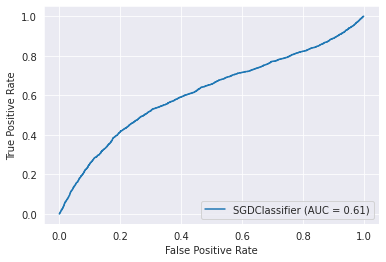

In [ ]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(max_iter=1000, tol=1e-3)
clf.fit(X_train, y_train)
y_pred_clf = clf.predict(X_valid)

auc_score_clf = roc_auc_score(y_pred_clf, y_valid)
print(f"AUC = {auc_score_clf}")
plot_roc_curve(clf, X_valid, y_valid)

Confusion matrix:
[[12714  2320]
 [  119    55]]


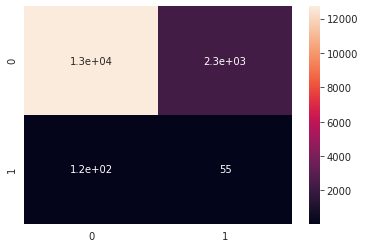

In [ ]:
confusion_clf = confusion_matrix(y_pred_clf,y_valid)
print("Confusion matrix:\n{}".format(confusion_clf))
sns.heatmap(confusion_clf, annot=True)

##MODEL 2: Logistic Regression

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   36.6s finished


              precision    recall  f1-score   support

          -1       0.90      0.74      0.82     12833
           1       0.29      0.58      0.39      2375

    accuracy                           0.72     15208
   macro avg       0.60      0.66      0.60     15208
weighted avg       0.81      0.72      0.75     15208

AUC = 0.5993355423003776


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


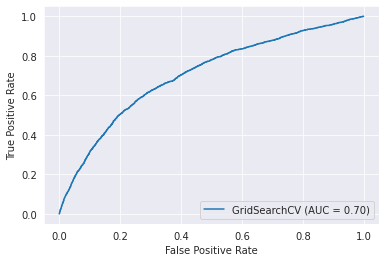

In [ ]:
# Initiate the Logistic Regression model
logreg = LogisticRegression()
param_grid = {'penalty': ['l1', 'l2'],
              'C': [1, 10, 100, 1000, 10000],#C là nghịch đảo của λ
              'class_weight': ['balanced']}

grid = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', verbose=True, n_jobs=-1)
best_clf = grid.fit(X_train, y_train)
best_clf.best_params_

# Calculate the prediction in test set
y_pred_logreg = best_clf.predict(X_valid)
# Print the metrics on test set
print(classification_report(y_valid, y_pred_logreg))

auc_score = roc_auc_score(y_pred_logreg, y_valid)
print(f"AUC = {auc_score}")
plot_roc_curve(best_clf, X_valid, y_valid)

Confusion matrix:
[[9549 1007]
 [3284 1368]]


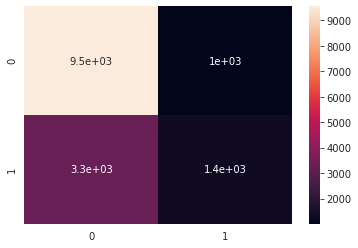

In [ ]:
confusion_logreg = confusion_matrix(y_pred_logreg,y_valid)
print("Confusion matrix:\n{}".format(confusion_logreg))
sns.heatmap(confusion_logreg, annot=True)